## TABLE DES MATIERES

### 0.1 Import Librairies
### 0.2 Read_csv
### 0.3


## 0. Import Librairies

In [3]:
import time
tic = time.time()

import numpy as np
import pandas as pd
import gc
import os
import glob
import shap

from contextlib import contextmanager

import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import mlflow
import mlflow.sklearn
from mlflow import MlflowClient

import sklearn
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score, confusion_matrix
from sklearn.metrics import classification_report, roc_curve
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import make_scorer, fbeta_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression

from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

from hyperopt import fmin, tpe, hp, STATUS_OK, Trials, space_eval

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.model_selection import cross_val_predict, cross_val_score, learning_curve, cross_validate

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

separator_line = '\n\n'+'\033[1m_\033[0m'*100+'\n'+'\033[1m_\033[0m'*100+'\n\n'
pd.set_option('display.max_rows', 4000)
pd.set_option('display.max_columns', 4000)
pd.set_option('display.width', 1000)

### 0.2 Read_csv

##### The column description csv file describes the Target field as follows:

1 - client with payment difficulties: he/she had late payment more than X days on at least one of the first Y installments of the loan in our sample

0 - all other cases

In [4]:
# DataFrame
df = pd.read_csv('./output_datasets/DataFrame.csv', index_col='SK_ID_CURR')

# Test
X_test = pd.read_csv('./output_datasets/X_test.csv')
y_test = pd.read_csv('./output_datasets/y_test.csv')

X_test = X_test.set_index('SK_ID_CURR')
y_test = y_test.set_index('SK_ID_CURR')

# Train
X_train = pd.read_csv('./output_datasets/X_train.csv')
y_train = pd.read_csv('./output_datasets/y_train.csv')

features = X_train.columns
# X_train = X_train.to_numpy()
y_train = y_train['TARGET'].to_numpy()

### 0.3 Display's functions

In [5]:
def cf_matrix_roc_auc(model, y_true, y_pred, y_pred_proba, features_importance_df=False, features=features, importance_range=30 ):
    '''This function will make a pretty plot of 
  an sklearn Confusion Matrix using a Seaborn heatmap visualization + ROC Curve.'''
    fig = plt.figure(figsize=(20,15))
  
    plt.subplot(221)
    cf_matrix = confusion_matrix(y_true, y_pred)
    cf_matrix_normalize_true = confusion_matrix(y_true, y_pred, normalize='true')
    cf_matrix_normalize_all = confusion_matrix(y_true, y_pred, normalize='all')
    
    group_names = ['True Neg', 'False Pos',  'False Neg', 'True Pos']
    group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.ravel()]
    group_normalize_true = ["{0:.2%}".format(value) for value in cf_matrix_normalize_true.ravel()]
    group_normalize_all = ["{0:.2%}".format(value) for value in cf_matrix_normalize_all.ravel()]
  
    labels = [f"{v1}\ncount : {v2}\nnormalize over true : {v3}\nnormalize over all : {v4}" for v1, v2, v3, v4 in zip(group_names,group_counts,group_normalize_true,group_normalize_all)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cf_matrix, annot=labels, fmt="", cmap='Blues')

    plt.subplot(222)
    fpr,tpr,_ = roc_curve(y_true, y_pred_proba)
    plt.plot(fpr, tpr, color='orange', linewidth=5)#, label='AUC = %0.4f' %roc_auc)
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()

    if type(features_importance_df)==type(pd.DataFrame()) : 
        plt.subplot(212)
        features_importance = features_importance_df.head(importance_range)
        
        sns.barplot(x=features_importance['feature'], y=features_importance['importance'], color=("orange"))
        plt.xlabel('Features importance')
        plt.xticks(rotation=90)
    plt.show()
    plt.close('all')
    return

In [6]:
def plt_scores(model_dict, keys_to_plot, title, x_lim=[0,0]):
    
    n = len(keys_to_plot)
    m = len(model_dict)
    
    plt.rcParams["figure.figsize"] = (3,3)
    plt.figure()
    plt.title(title, fontsize=20)
    plt.ylabel('Model',fontsize=10)
    plt.xlabel('score',fontsize=10)
    
    X_axis = np.arange(m)
    width=1/(n+1)
    
    i=0
    for key in keys_to_plot:
        values = [t[key] for t in model_dict.values()]
        plt.barh((X_axis-(width/2))+(width*i), values, width, label=key)
        i+=1
    
    plt.yticks(X_axis, model_dict.keys())
    if x_lim==[0,1]:
        plt.xlim(x_lim)
    plt.tick_params( length =5, labelsize=10)
    plt.grid(linewidth=0.5, color = 'black')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.margins(0.001)
    plt.show()
    plt.close()
    return

def plt_time(model_list, time_list):
    n = len(model_list)
    
    X_axis = np.arange(n)
    width=1/(n+1)
    
    plt.rcParams["figure.figsize"] = (3,3)
    plt.figure()
    plt.title('Execution Time', fontsize=20)
    plt.ylabel('Model',fontsize=10)
    plt.xlabel('Time',fontsize=10)
    plt.barh(X_axis,time_list,width)
    plt.yticks(X_axis, model_list)
    plt.tick_params(length =5, labelsize=10)
    plt.grid(linewidth=0.5, color = 'black')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.margins(0.001)
    plt.show()
    plt.close()
    return
    
    

In [7]:
@contextmanager
def timer(title):
    t0 = time.time()
    yield
    print("{} - done in {:.0f}s\n\n".format(title, time.time() - t0)+"-"*50)

### 1.1 Classification's models

### 1.1 Scores

In [8]:
# https://en.wikipedia.org/wiki/Sensitivity_and_specificity#Specificity




# pos_label

fbeta_0_5_scorer = make_scorer(fbeta_score, beta=0.5)

In [9]:
def create_or_read_model(create=False, version=1, score='roc_auc',cv=5, reg_model_name=None, Estimator=None, param_grid=None):
    if create==True:
        time_start = time.time()
        with mlflow.start_run(run_name=reg_model_name) as run:
            
            grid = GridSearchCV(eval(Estimator),
                                param_grid=param_grid,
                                scoring=score,
                                cv=cv,
                                verbose=10)
            
            grid.fit(X_train, y_train)
            mlflow.log_params(param_grid)
            mlflow.sklearn.log_model(sk_model = grid,
                                    artifact_path="classifier",
                                    registered_model_name=reg_model_name)
        time_end = time.time()
        model = grid
        execution_time = round((time_end-time_start)/60,2)
        np.save(f'./Execution_model_time/{reg_model_name}_{version}.npy', np.array(execution_time))
    elif create==False :
        model_uri = f"models:/{reg_model_name}/{version}"
        model = mlflow.sklearn.load_model(model_uri)
        execution_time = np.load(f'./Execution_model_time/{reg_model_name}_{version}.npy')
        
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)
    model_best_score = model.best_score_
    roc_score = roc_auc_score(y_pred, y_test)
    beta_score_5 = fbeta_score(y_pred, y_test, beta=5)
    beta_score_0_25 = fbeta_score(y_pred, y_test, beta=0.25)
    recall = recall_score(y_pred, y_test)
    precision = precision_score(y_pred, y_test)

    #OUTPUT

    print('\n\n'+reg_model_name+' : ')
    print(f"\n\texecution time : {execution_time}")
    print(f"\n\tbest_score_ : {round(model_best_score,3)}")
    print(f"\n\troc_auc_score : {round(roc_score,3)}")
    print(f"\n\tbeta_score beta=5 : {round(beta_score_5,3)}")
    print(f"\n\tbeta_score beta=0.25 : {round(beta_score_0_25,3)}")
    print(f"\n\trecall_score : {round(recall,3)}")
    print(f"\n\tprecision_score : {round(precision,3)}")
    
    cf_matrix_roc_auc(model, y_test, y_pred, y_pred_proba[:,1], features_importance_df=False)
    print(separator_line)
    
    return {'model':model, 
            'model_best_score':model_best_score, 
            'roc_score':roc_score, 
            'beta_score_5':beta_score_5 , 
            'beta_score_0_25':beta_score_0_25,
            'recall_score': recall,
            'precision_score':precision,       
            'time':execution_time
           }

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.




DummyClassifier : 

	execution time : 0.14

	best_score_ : 0.5

	roc_auc_score : 0.5

	beta_score beta=5 : 0.084

	beta_score beta=0.25 : 0.384

	recall_score : 0.081

	precision_score : 0.501


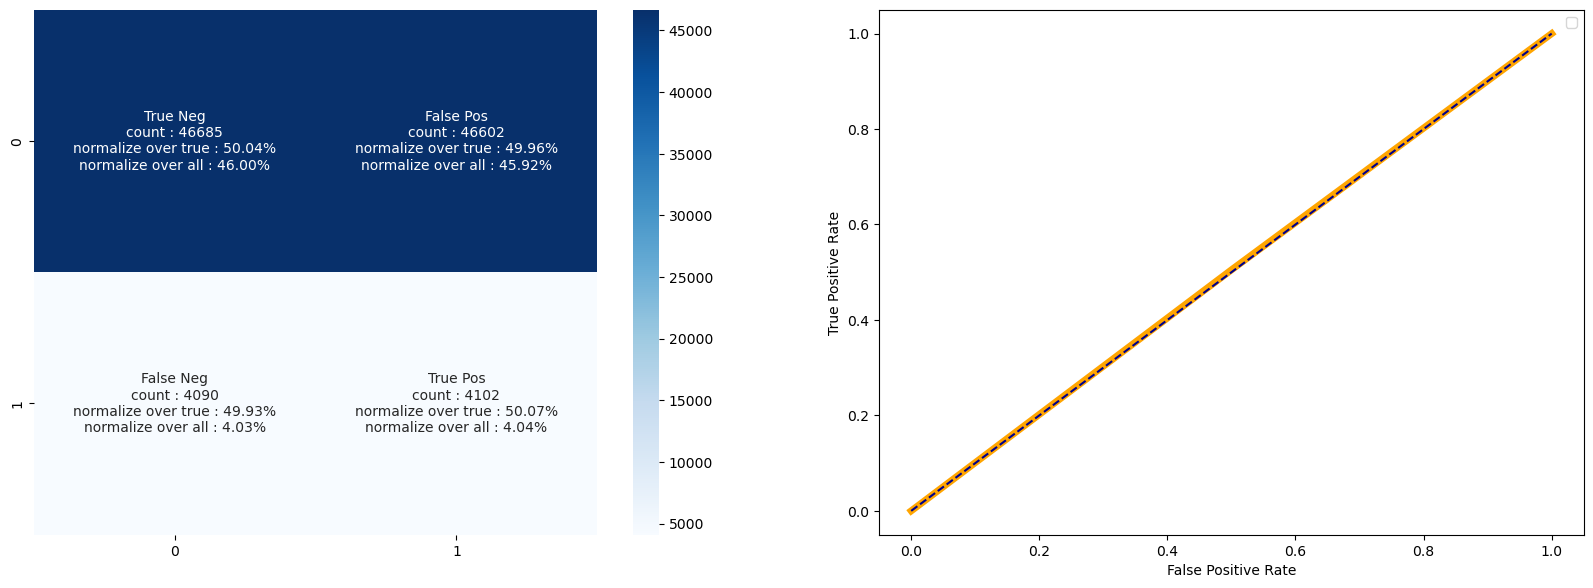



____________________________________________________________________________________________________
____________________________________________________________________________________________________




No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.




LogisticRegression : 

	execution time : 4.53

	best_score_ : 0.805

	roc_auc_score : 0.563

	beta_score beta=5 : 0.172

	beta_score beta=0.25 : 0.554

	recall_score : 0.167

	precision_score : 0.648


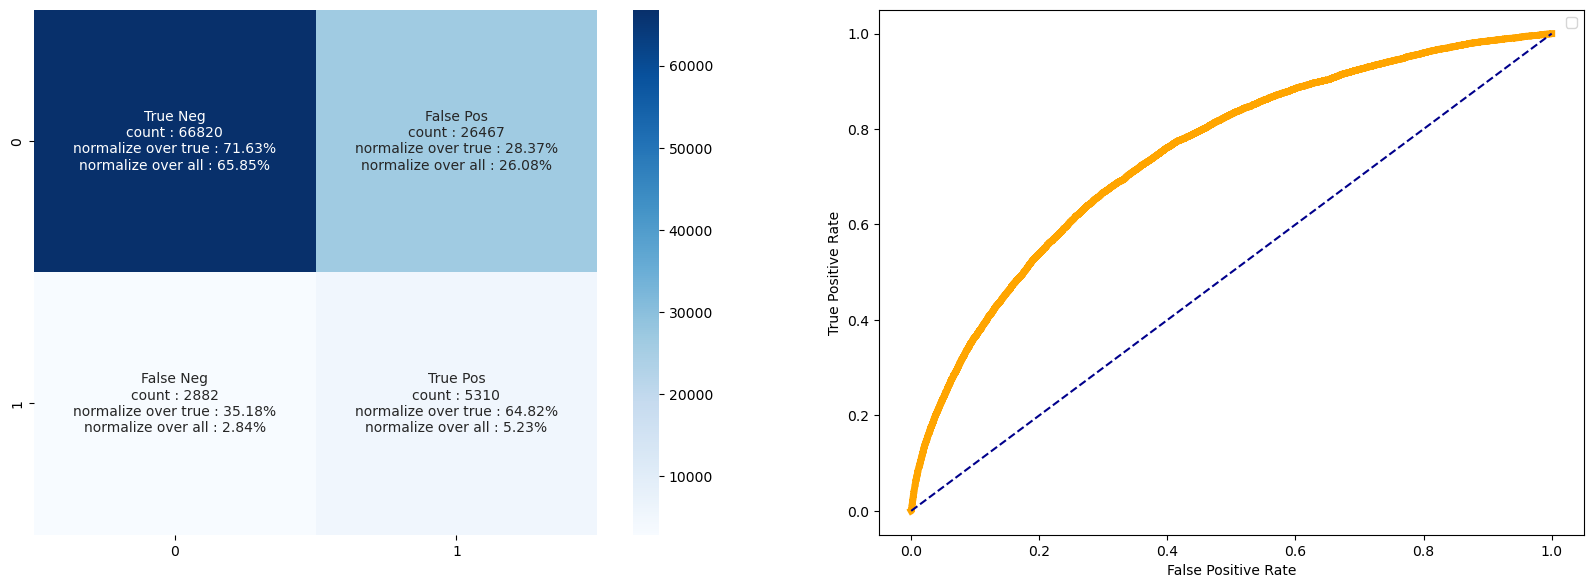



____________________________________________________________________________________________________
____________________________________________________________________________________________________




No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.




RandomForestClassifier : 

	execution time : 80.32

	best_score_ : 0.985

	roc_auc_score : 0.608

	beta_score beta=5 : 0.183

	beta_score beta=0.25 : 0.018

	recall_score : 0.296

	precision_score : 0.017


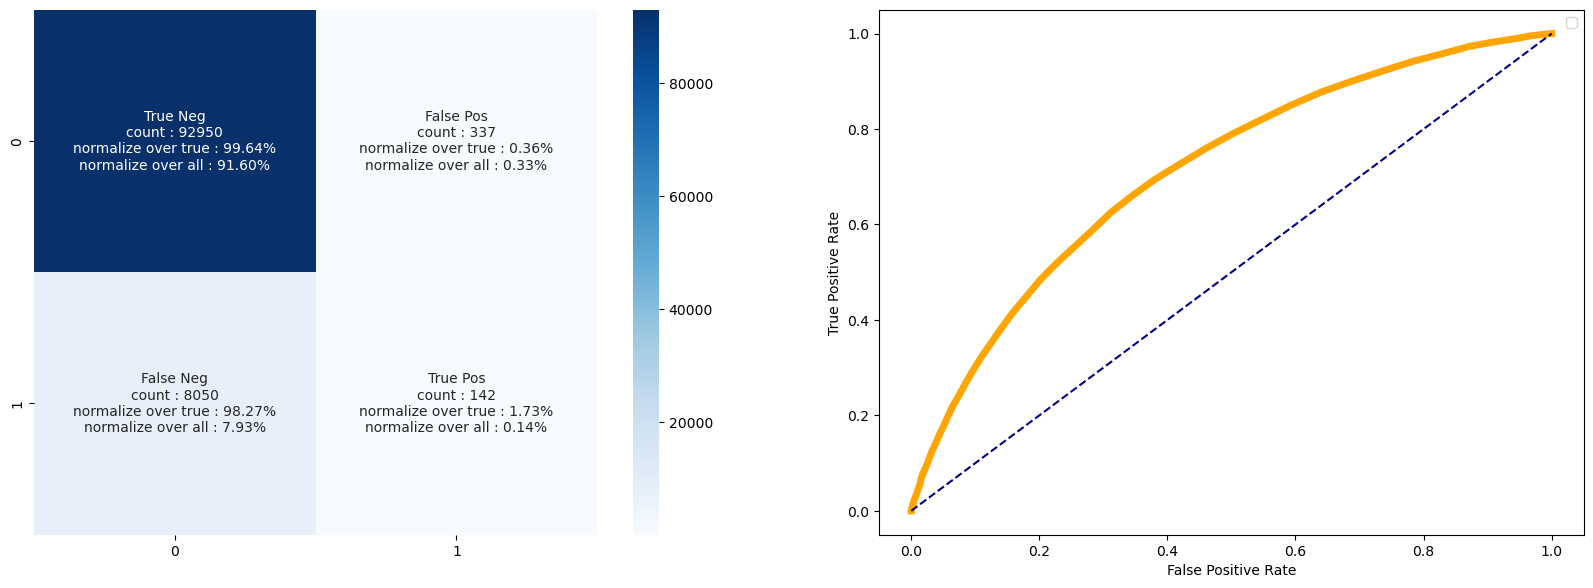



____________________________________________________________________________________________________
____________________________________________________________________________________________________




No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.




LGBMClassifier : 

	execution time : 9.68

	best_score_ : 0.969

	roc_auc_score : 0.735

	beta_score beta=5 : 0.356

	beta_score beta=0.25 : 0.039

	recall_score : 0.548

	precision_score : 0.036


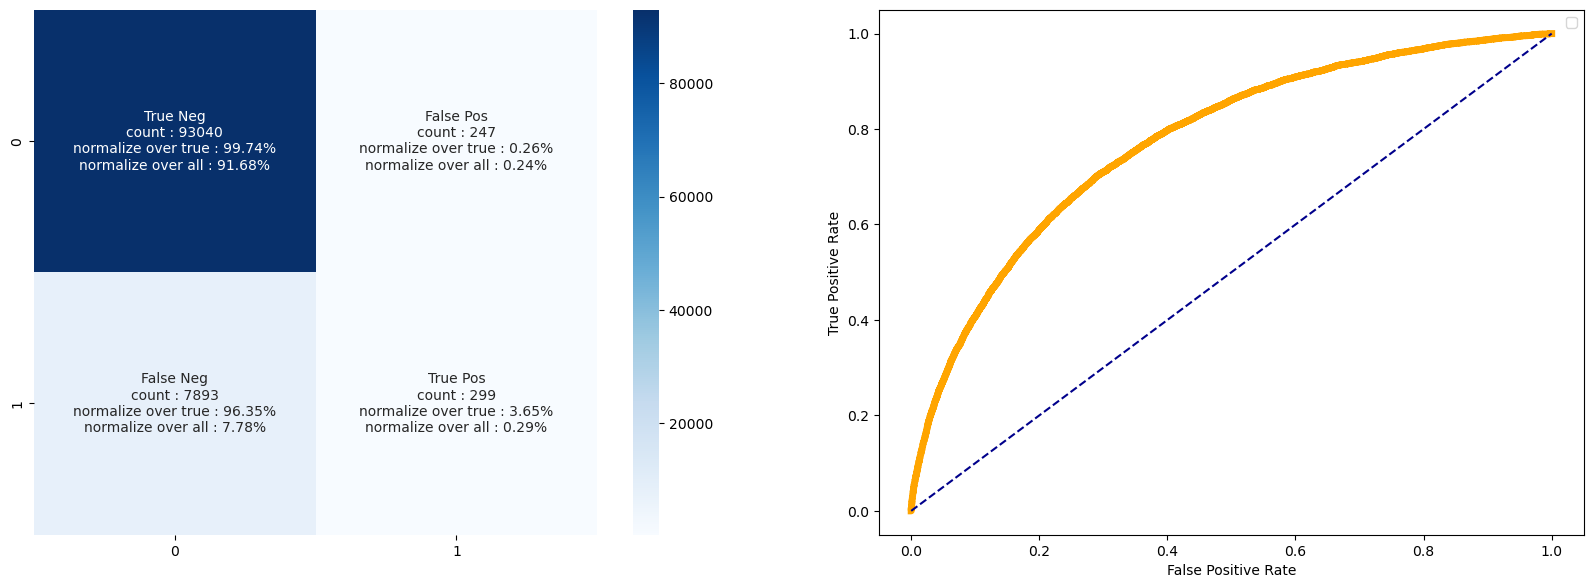



____________________________________________________________________________________________________
____________________________________________________________________________________________________




In [10]:
model_dict ={}
model_dict["DummyClassifier"] = create_or_read_model(create=False, 
                                    version=1, 
                                    score='roc_auc',
                                    cv=5, 
                                    reg_model_name="DummyClassifier", 
                                    Estimator="DummyClassifier()", 
                                    param_grid={'strategy' : ['stratified', 'uniform']})

model_dict["LogisticRegression"] = create_or_read_model(create=False, 
                                    version=1, 
                                    score='roc_auc',
                                    cv=5, 
                                    reg_model_name="LogisticRegression", 
                                    Estimator="LogisticRegression()", 
                                    param_grid = {'penalty' : ['l2'],
                                                  'max_iter' : [1000]}
                                    )
model_dict["RandomForestClassifier"] = create_or_read_model(create=False, 
                                    version=1, 
                                    score='roc_auc',
                                    cv=5, 
                                    reg_model_name="RandomForestClassifier", 
                                    Estimator="RandomForestClassifier()", 
                                    param_grid = {'criterion' : ['gini', 'entropy'],
                                                  'max_depth' : [200]}
                                    )
model_dict["LGBMClassifier"] = create_or_read_model(create=False, 
                                    version=1, 
                                    score='roc_auc',
                                    cv=5, 
                                    reg_model_name="LGBMClassifier", 
                                    Estimator="LGBMClassifier()", 
                                    param_grid = {'n_estimators' : [1000],
                                      'learning_rate' : [0.02],
                                      'max_depth' : [8]}
                                    )

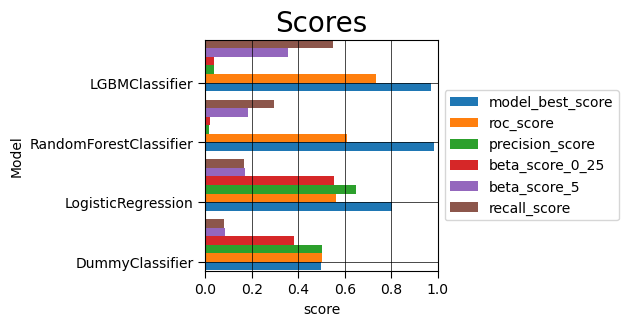

In [11]:
plt_scores(model_dict, 
           keys_to_plot=['model_best_score',
                         'roc_score',
                         'precision_score',
                         'beta_score_0_25',
                         'beta_score_5',
                         'recall_score'],
           title='Scores',
           x_lim=[0,1])

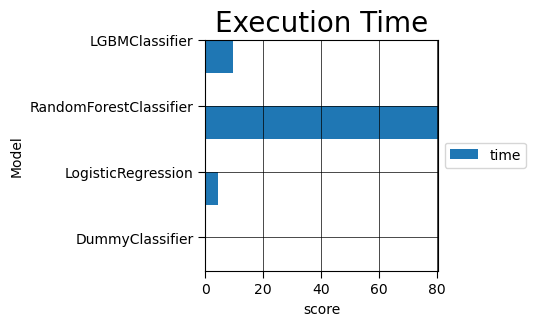

In [12]:
plt_scores(model_dict, 
           keys_to_plot=['time'],
           title='Execution Time')

Specificity score:
https://en.wikipedia.org/wiki/Sensitivity_and_specificity#Specificity

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


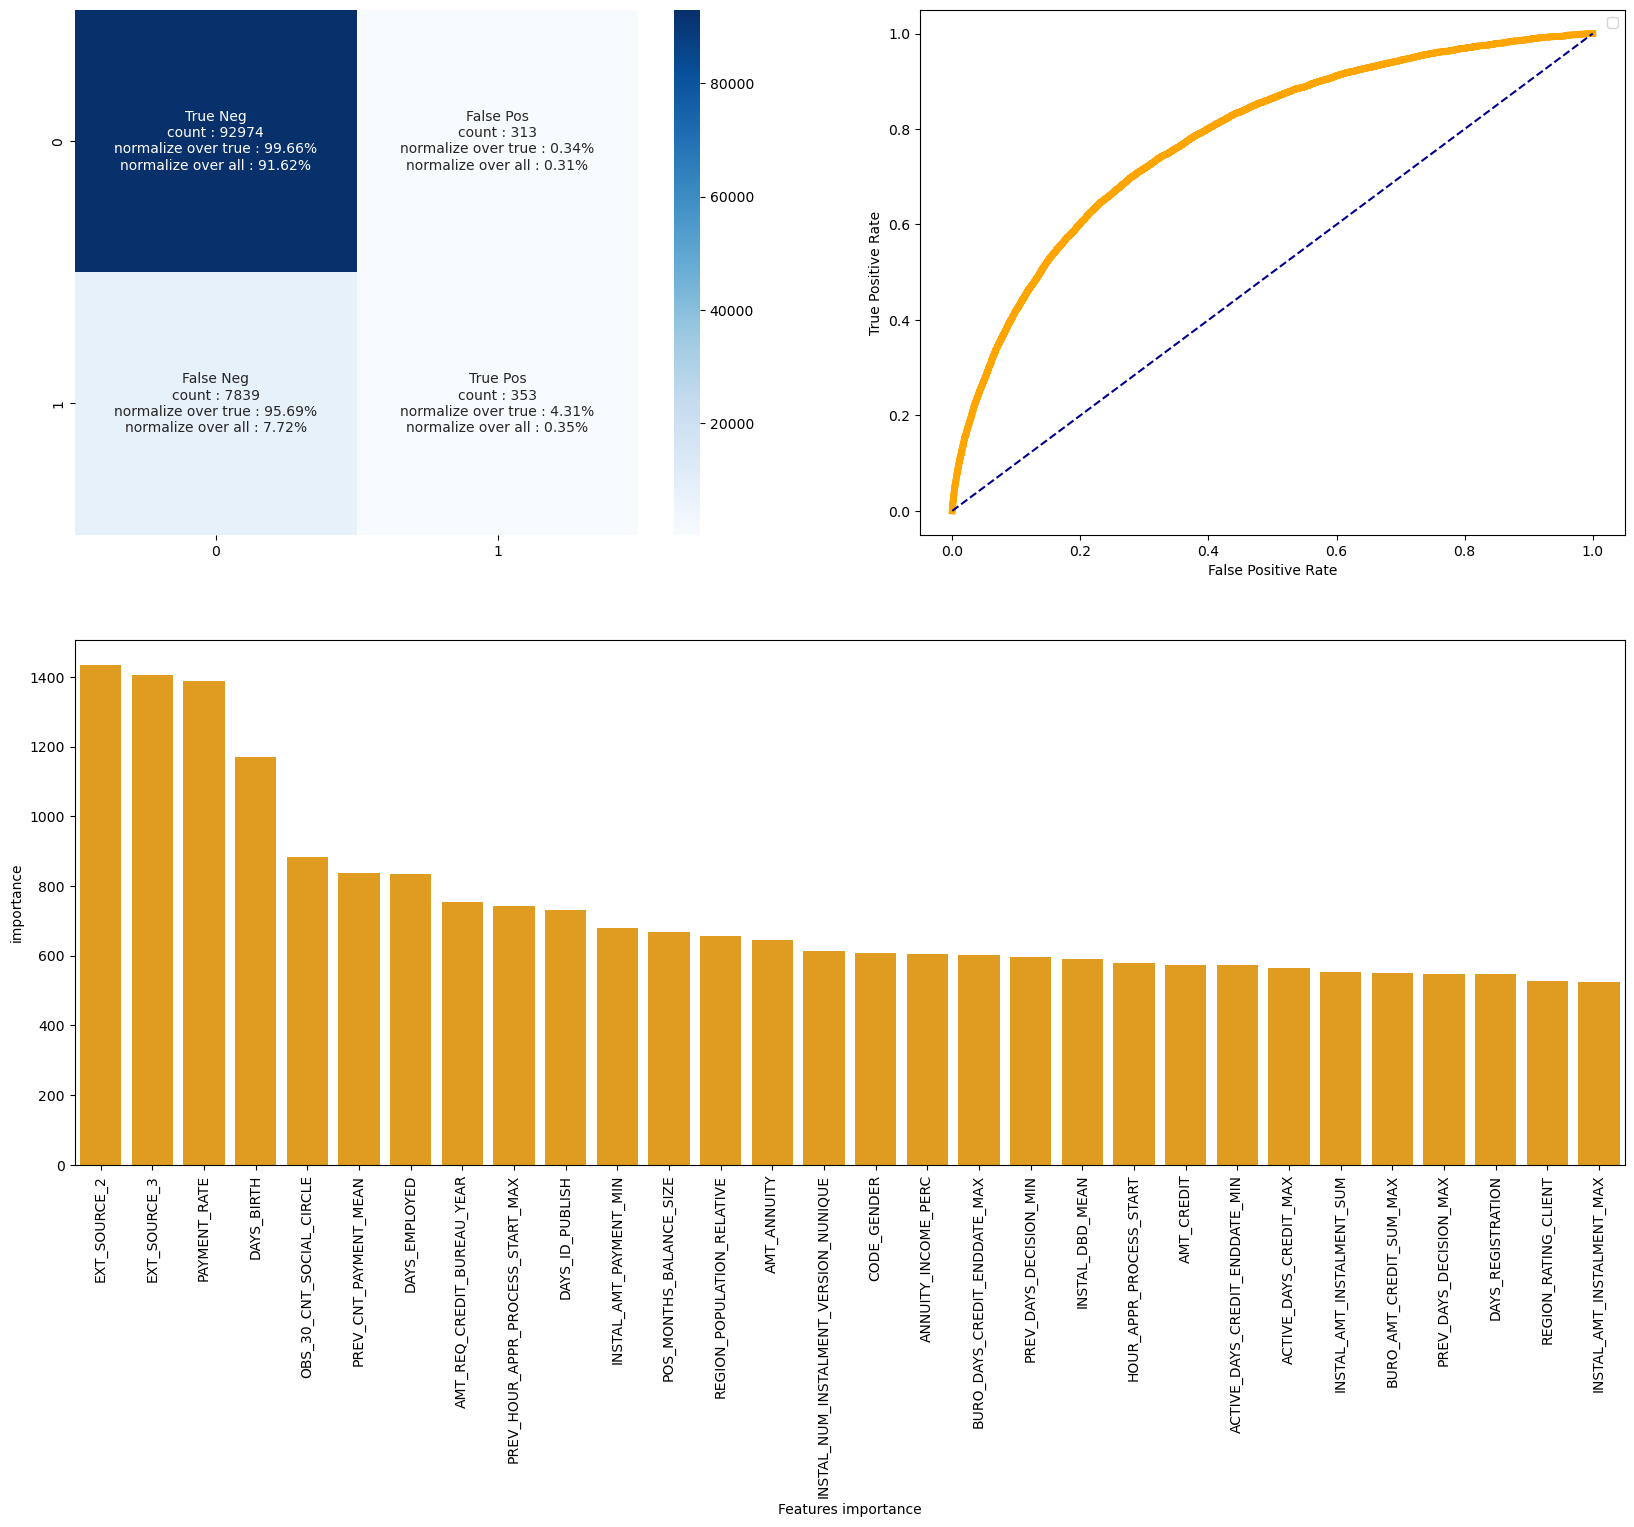

In [13]:
device = 'gpu'
n_estimators = 2000
max_depth=30
n_KFolds = 3
max_evals = 10


def objective(params):
    params = {
        'reg_alpha' : int(params['reg_alpha']),
        'min_child_weight' : int(params['min_child_weight']),
        'learning_rate': params['learning_rate'],
        'colsample_bytree': params['colsample_bytree'],
        'reg_lambda': params['reg_lambda'],
        'device' : device,
        'n_estimators': n_estimators,
        'max_depth':max_depth
        }
    model= LGBMClassifier(**params)
    cv = StratifiedKFold(n_KFolds)
    y_pred = cross_val_predict(model, X_train, y_train, method='predict', cv=cv)
    beta_score = fbeta_score(y_train, y_pred, beta=50)
#     specificity= specificity_score(y_pred,y_train)
    return {'loss': (1 - beta_score), 'status': STATUS_OK }

def LGBM_hyperopt(run_name, create, version=1):
    if create ==True:
        space = {
            'learning_rate': hp.uniform('learning_rate', 0.001, 0.03),
            'reg_alpha' : hp.quniform('reg_alpha', 40,180,5),
            'colsample_bytree': hp.uniform('colsample_bytree', 0.60, 0.95),
            'reg_lambda': hp.uniform('reg_lambda', 1, 20),
            'min_child_weight' : hp.quniform('min_child_weight', 5, 10, 1),
            }
        trials = Trials()
        best = fmin(fn=objective, space=space, max_evals=max_evals, algo=tpe.suggest)
        with mlflow.start_run(run_name=run_name) as run:
            lgbm = LGBMClassifier(
                max_depth= max_depth,
                reg_alpha=int(best['reg_alpha']),
                min_child_weight=int(best['min_child_weight']),
                learning_rate= best['learning_rate'],
                colsample_bytree= best['colsample_bytree'],
                reg_lambda= best['reg_lambda'],
                n_estimators=n_estimators,
                device=device
                )
            lgbm.fit(X_train, y_train)
            mlflow.log_params(best)
            mlflow.sklearn.log_model(sk_model = lgbm,
                                        artifact_path="classifier",
                                        registered_model_name=run_name)
        model = lgbm
    else:
        model_uri=f"models:/{run_name}/{version}"
        model=mlflow.sklearn.load_model(model_uri)
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)
    feature_importance_df = pd.DataFrame()
    feature_importance_df['feature'] = features
    feature_importance_df['importance'] = model.feature_importances_
    feature_importance_df['importance_abs']= abs(feature_importance_df['importance'])
    feature_importance_df = feature_importance_df.sort_values('importance_abs', ascending=False)  
    cf_matrix_roc_auc(model, y_test, y_pred, y_pred_proba[:,1], features_importance_df=feature_importance_df)
    return
LGBM_hyperopt(run_name='LGBM_Hyperopt_fscore', create=False, version=2)

In [14]:
def X_sample(create=False):
    if create:
        X_test_sample = X_test.sample(300)
        X_test_sample.to_csv('./output_datasets/X_test_sample.csv')
        X_test_sample.to_csv(r"C:\Users\emanu\Documents\FastAPI\X_test_sample.csv")
        X_test_sample.to_csv(r"C:\Users\emanu\Documents\Dash_app\X_test_sample.csv")
    X_test_sample = pd.read_csv('./output_datasets/X_test_sample.csv',index_col='SK_ID_CURR')
    return X_test_sample

def shap_model_feat_importance(X_test_sample, create=False, model_uri="models:/LGBM_Hyperopt_specificity/1" ):
    # LOAD MODEL
    model = mlflow.sklearn.load_model(model_uri)
    if create:
        # shap
        with mlflow.start_run() as run:
            mlflow.shap.log_explanation(model.predict, X_test_sample)
        client = MlflowClient()
        artifact_path = "model_explanations_shap"
        artifacts = [x.path for x in client.list_artifacts(run.info.run_id, artifact_path)]
        dst_path = client.download_artifacts(run.info.run_id, artifact_path)
        base_values = np.load(os.path.join(dst_path, "base_values.npy"))
        shap_values = np.load(os.path.join(dst_path, "shap_values.npy"))
        
        # predict
        y_pred_proba = model.predict_proba(X_test)
        y_pred_proba = list(zip(*y_pred_proba))
        prediction_proba_0 = np.array(y_pred_proba[0])*100
        
        feature_importance_df = pd.DataFrame()
        feature_importance_df['feature'] = features
        feature_importance_df['importance'] = model.feature_importances_
        feature_importance_df['importance_abs']= abs(feature_importance_df['importance'])
        feature_importance_df = feature_importance_df.sort_values('importance_abs', ascending=False)
        
        df_sample = df.loc[:,feature_importance_df.head(50)['feature']]
        
        # save results on Projet_7 folder
        np.save("./output_datasets/model_explanations_shap/base_values.npy",base_values)
        np.save("./output_datasets/model_explanations_shap/shap_values.npy",shap_values)
        np.save("./output_datasets/all_prediction.npy",prediction_proba_0)
        feature_importance_df.to_csv("./output_datasets/feature_importance_df.csv", index=False)
        # save results on FastAPI folder
        np.save(r"C:\Users\emanu\Documents\FastAPI\model_explanations_shap\base_values.npy",base_values)
        np.save(r"C:\Users\emanu\Documents\FastAPI\model_explanations_shap\shap_values.npy",shap_values)
        feature_importance_df.to_csv(r"C:\Users\emanu\Documents\FastAPI\feature_importance_df.csv", index=False)
        # save results on Dash_app folder
        np.save(r"C:\Users\emanu\Documents\Dash_app\model_explanations_shap\base_values.npy",base_values)
        np.save(r"C:\Users\emanu\Documents\Dash_app\model_explanations_shap\shap_values.npy",shap_values)
        np.save(r"C:\Users\emanu\Documents\Dash_app\all_proba.npy",prediction_proba_0)
        df_sample.to_csv(r"C:\Users\emanu\Documents\Dash_app\DataFrame.csv", index=False)
        feature_importance_df.to_csv(r"C:\Users\emanu\Documents\Dash_app\feature_importance_df.csv", index=False)
        
    # read
    base_values = np.load("./output_datasets/model_explanations_shap/base_values.npy")
    shap_values = np.load("./output_datasets/model_explanations_shap/shap_values.npy")
    feature_importance_df = pd.read_csv('./output_datasets/feature_importance_df.csv',index_col='feature')

    return base_values, shap_values, feature_importance_df


# run functions
X_test_sample = X_sample(create=False)
base_values, shap_values, feature_importance_df = shap_model_feat_importance(X_test_sample, create=False, model_uri="models:/LGBM_Hyperopt_fscore/2")

# SHOW
print('X_test_sample')
display(X_test_sample.head(5))
print('base_values')
print(base_values)
print('shap_values')
print(shap_values)
print('feature_importance_df')
feature_importance_df.head(5)

X_test_sample


CODE_GENDER  FLAG_OWN_CAR  FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  DAYS_REGISTRATION  DAYS_ID_PUBLISH  FLAG_EMP_PHONE  FLAG_WORK_PHONE  FLAG_PHONE  FLAG_EMAIL  REGION_RATING_CLIENT  HOUR_APPR_PROCESS_START  REG_REGION_NOT_LIVE_REGION  REG_REGION_NOT_WORK_REGION  REG_CITY_NOT_LIVE_CITY  REG_CITY_NOT_WORK_CITY  EXT_SOURCE_2  EXT_SOURCE_3  YEARS_BEGINEXPLUATATION_AVG  FLOORSMAX_AVG  TOTALAREA_MODE  OBS_30_CNT_SOCIAL_CIRCLE  DEF_30_CNT_SOCIAL_CIRCLE  DAYS_LAST_PHONE_CHANGE  FLAG_DOCUMENT_2  FLAG_DOCUMENT_3  FLAG_DOCUMENT_4  FLAG_DOCUMENT_6  FLAG_DOCUMENT_7  FLAG_DOCUMENT_8  FLAG_DOCUMENT_9  FLAG_DOCUMENT_10  FLAG_DOCUMENT_11  FLAG_DOCUMENT_13  FLAG_DOCUMENT_14  FLAG_DOCUMENT_15  FLAG_DOCUMENT_16  FLAG_DOCUMENT_17  FLAG_DOCUMENT_18  FLAG_DOCUMENT_19  FLAG_DOCUMENT_21  AMT_REQ_CREDIT_BUREAU_DAY  AMT_REQ_CREDIT_BUREAU_WEEK  AMT_REQ_CREDIT_BUREAU_MON  AMT_REQ_CREDIT_BUREAU_QRT  \
SK_ID_CURR                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               
266505        -1.386536      1.393289         -0.66412      0.808707          0.441080    2.888169     1.675021                    3.735327   -0.053848      -0.359646          -0.954330        -0.746451        0.468731         2.004513    1.601330   -0.245392             -2.067703                -0.325156                   -0.123778                   -0.232336               -0.290638               -0.547155      1.118931      0.113091                     0.047517       -0.27961       -0.221013                 -0.582471                 -0.318642               -2.669488        -0.007307        -1.565255        -0.009603        -0.310360        -0.012847         3.355399        -0.061646         -0.004406         -0.061128         -0.057841         -0.054448         -0.033357         -0.100644         -0.016489         -0.090097         -0.024639         -0.018303                  -0.058775                   -0.155354                  -0.269070                  -0.396044   
436396         0.721160     -0.717726         -0.66412     -0.579881         -0.083683   -0.929694    -1.298087                    0.140363   -1.320463       0.283016          -0.132838        -1.132237       -2.133419        -0.498874   -0.624481   -0.245392             -0.103188                -0.631499                   -0.123778                   -0.232336               -0.290638               -0.547155      0.562914      1.320694                     0.047517       -0.27961       -0.221013                  1.059805                 -0.318642               -0.531004        -0.007307        -1.565255        -0.009603         3.222069        -0.012847        -0.298027        -0.061646         -0.004406         -0.061128         -0.057841         -0.054448         -0.033357         -0.100644         -0.016489         -0.090097         -0.024639         -0.018303                  -0.058775                   -0.155354                   0.901353                  -0.396044   
101771         0.721160      1.393289         -0.66412     -0.579881

base_values
0.4966666666666667
shap_values
[[ 0.02337182 -0.03028911  0.         ... -0.00507554 -0.01273277
  -0.00641302]
 [ 0.          0.          0.01334864 ...  0.03136754  0.
   0.        ]
 [-0.00742436 -0.09022445 -0.0022244  ...  0.0204046  -0.03883076
   0.00385093]
 ...
 [ 0.04093511  0.          0.         ...  0.0266452  -0.00542646
   0.00455776]
 [ 0.          0.          0.         ...  0.03140038  0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
feature_importance_df


importance  importance_abs
feature                                             
EXT_SOURCE_2                    1435            1435
EXT_SOURCE_3                    1406            1406
PAYMENT_RATE                    1388            1388
DAYS_BIRTH                      1170            1170
OBS_30_CNT_SOCIAL_CIRCLE         884             884

## DataDrift

https://github.com/evidentlyai/evidently

In [20]:
model = mlflow.sklearn.load_model("models:/LGBM_Hyperopt_fscore/2")

In [ ]:
X_train_copy = X_train.copy()
X_test_copy = X_test.copy()
X_train_copy['target'] = y_train
X_test_copy['target']=model.predict(X_test)

In [ ]:
# X_train_copy = X_train.copy()
# X_test_copy = X_test_sample.copy()
# X_train_copy['target'] = y_train
# X_test_copy['target']=model.predict(X_test_sample)

In [ ]:
# X_train_copy = X_train_copy.sample(300)
# X_test_copy = X_test_copy.sample(300)

In [ ]:
from evidently.report import Report
from evidently.metric_preset import DataDriftPreset

In [ ]:
data_drift_report = Report(metrics=[DataDriftPreset()])
data_drift_report.run(reference_data=X_train_copy, current_data=X_test_copy, column_mapping=None)
data_drift_report

In [ ]:
data_drift_report.save_html("./data_drift_check-dashboard.html")

In [39]:
data_drift_report..json()

In [37]:
# model = mlflow.sklearn.load_model("models:/LGBM_Hyperopt_fscore/2")
# feature_importance_df = pd.DataFrame()
# feature_importance_df['feature'] = features
# feature_importance_df['importance'] = model.feature_importances_
# feature_importance_df['importance_abs']= abs(feature_importance_df['importance'])
# feature_importance_df = feature_importance_df.sort_values('importance_abs', ascending=False)
# df_sample = df.loc[df.index.isin(X_test_sample.index)]
# # df_sample = df.loc[df.index.isin(X_test_sample.index),feature_importance_df.head(50)['feature']]
# df_sample.to_csv(r"C:\Users\emanu\Documents\Dash_app\DataFrame.csv")#, index=False)

In [35]:
df_sample.shape

(300, 391)

In [36]:
df_sample

TARGET  CODE_GENDER  FLAG_OWN_CAR  FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  DAYS_REGISTRATION  DAYS_ID_PUBLISH  FLAG_EMP_PHONE  FLAG_WORK_PHONE  FLAG_PHONE  FLAG_EMAIL  REGION_RATING_CLIENT  HOUR_APPR_PROCESS_START  REG_REGION_NOT_LIVE_REGION  REG_REGION_NOT_WORK_REGION  REG_CITY_NOT_LIVE_CITY  REG_CITY_NOT_WORK_CITY  EXT_SOURCE_2  EXT_SOURCE_3  YEARS_BEGINEXPLUATATION_AVG  FLOORSMAX_AVG  TOTALAREA_MODE  OBS_30_CNT_SOCIAL_CIRCLE  DEF_30_CNT_SOCIAL_CIRCLE  DAYS_LAST_PHONE_CHANGE  FLAG_DOCUMENT_2  FLAG_DOCUMENT_3  FLAG_DOCUMENT_4  FLAG_DOCUMENT_6  FLAG_DOCUMENT_7  FLAG_DOCUMENT_8  FLAG_DOCUMENT_9  FLAG_DOCUMENT_10  FLAG_DOCUMENT_11  FLAG_DOCUMENT_13  FLAG_DOCUMENT_14  FLAG_DOCUMENT_15  FLAG_DOCUMENT_16  FLAG_DOCUMENT_17  FLAG_DOCUMENT_18  FLAG_DOCUMENT_19  FLAG_DOCUMENT_21  AMT_REQ_CREDIT_BUREAU_DAY  AMT_REQ_CREDIT_BUREAU_WEEK  AMT_REQ_CREDIT_BUREAU_MON  AMT_REQ_CREDIT_BUREAU_QRT  \
SK_ID_CURR                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       
101771           0            1             1                0             0         157500.00    479974.5      26167.5                    0.035792      -22885        -2769.0              -70.0            -4782               1                0           0           0                     2                       12                           0                           0                       0                       1      0.638871      0.368969                       0.9816         0.1667          0.0688                       0.0                       0.0                 -1746.0                0                0                0                1                0                0                0                 0                 0                 0                 0                 0                 0                 0                 0                 0                 0                        0.0                         0.0                        0.0                        0.0   
101849           0            1             0                0             0         112500.00    536917.5      29254.5                    0.007114      -18283        -1648.0            -1162.0            -1841               0                0           0           1                     2                       15                           0                           0                       0                       0      0.344424      0.798137                       0.9841         0.1667          0.1031                       0.0                       0.0                  -732.0                0                1                0                0                0                0                0                 0                 0                 0                 0                 0                 0                 0                 0                 0                 0                        0.0                         0.0                        1.0                        0.0   
102078           0            1     

In [13]:
toc=time.time()
print(f"Notebook execution time : {round((toc-tic)/60,2)} min")

Notebook execution time : 1.24 min
